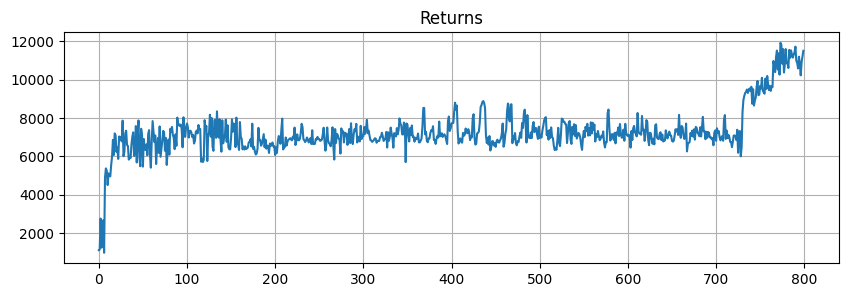

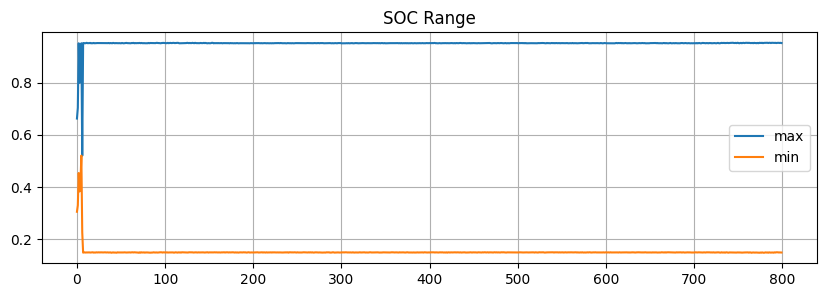

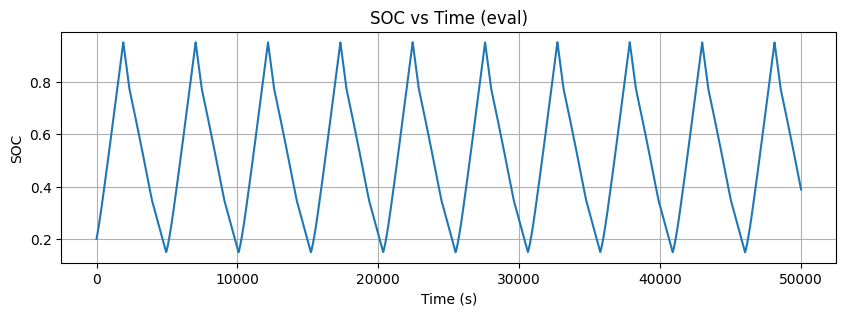

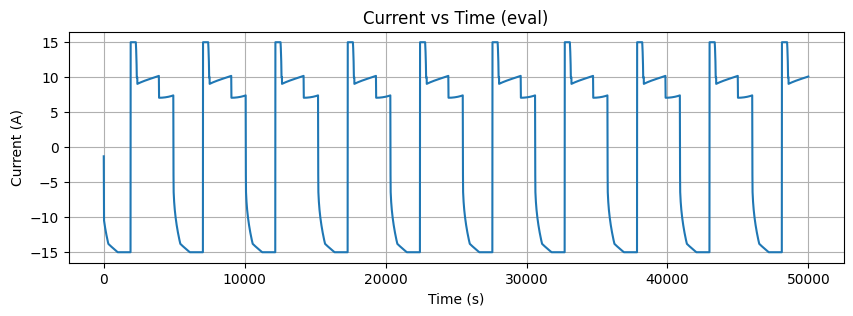

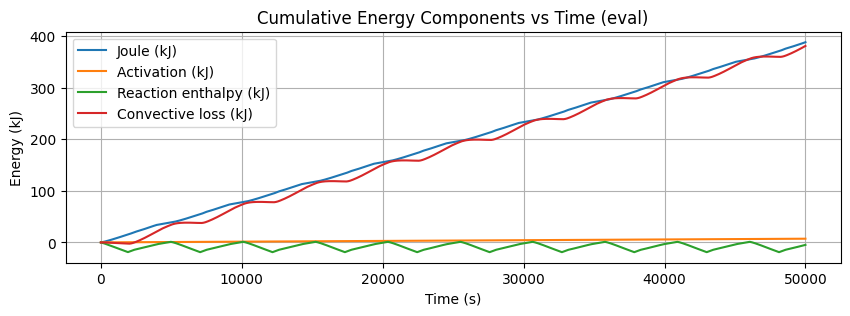

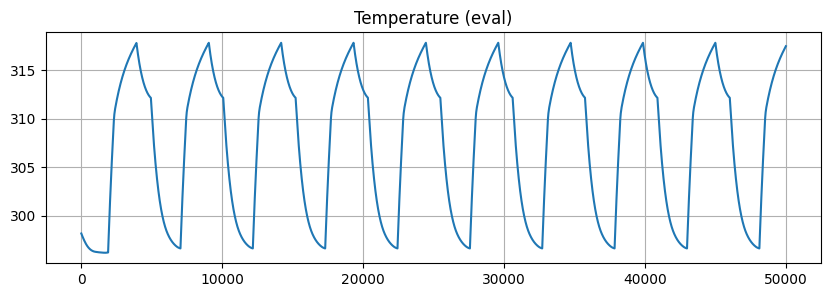

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# ------------------------------------
# CONSTANTS 
# ------------------------------------
F = 96485.33     
R = 8.314        
T0 = 298.15
n = 1            
E0 = 1.26        

C_tot = 1500.0        
V_elec = 0.001
A_elec = 0.5
i0 = 50.0              
alpha = 0.5

dt = 5.0
T_amb = 298.15

nu_H = 2.0
SOC_SCALE = 4.0       

R_ref = 0.05      
Q_ref = 1.67e-5
beta = 0.25

I_max = 15.0
dI_max = 5.0

V_discharge_nom = 0.9
V_charge_nom = 1.8      

k_cross = 2e-6          

deltaH_rxn = -67.4e3

C_th = 500.0
hA = 0.8
T_min = 250
T_max = 400

T_TARGET = 310.15

# Updated reward weights for better thermal control
TEMP_W = 1.5
TEMP_OVER_MARGIN = 5.0
TEMP_OVER_W = 4.0
HOT_LINEAR_W = 0.3        # NEW: linear heat penalty

SOC_W = 800.0
P_EL_W = 0.15
ALIVE_BONUS = 2.0
WRONG_SIGN_W = 40.0
CYCLE_BONUS = 500.0

T_amb_base = T_amb


# ------------------------------------
# ELECTROCHEMISTRY / THERMAL FUNCTIONS
# ------------------------------------
def soc_coulomb(I, soc_prev):
    soc_new = soc_prev - SOC_SCALE * (I*dt)/(n*F*C_tot*V_elec)
    return float(np.clip(soc_new, 1e-6, 1-1e-6))

def eta_act(I, T):
    j = np.abs(I) / A_elec + 1e-12
    arg = np.maximum(1e-12, j/(2*i0))
    eta = (R*T)/(alpha*n*F) * np.arcsinh(arg)
    return np.sign(I)*eta

def E_ocv(soc, T, H):
    s = np.clip(soc, 1e-6, 1-1e-6)
    return E0 + (2*R*T/F)*(np.log((1-s)/s) + np.log(H+1e-12))

def R_ohm(T, Q):
    T = max(250, T)
    Q = max(1e-9, Q)
    return float(R_ref * (298.15/T) * (Q_ref/Q)**beta)

def temperature_next(T_prev,I,Rohm,eta):
    Q_j = I**2 * Rohm
    Q_a = abs(I)*abs(eta)
    Q_rx = - I*(deltaH_rxn)/F
    Q_gen = Q_j + Q_a + Q_rx
    Q_loss = hA*(T_prev-T_amb)
    T_new = T_prev + (Q_gen-Q_loss)/C_th * dt
    return float(np.clip(T_new,T_min,T_max)),Q_j,Q_a,Q_rx,Q_loss

def H_next(H_prev,I):
    delta_H = -(nu_H * I * dt) / (F * V_elec)
    return float(np.clip(H_prev+delta_H,1e-3,5000.0))

def current_from_Vset(V_set,soc,T,H,Q,I_prev=None):
    Rohm = R_ohm(T,Q)
    Eo = E_ocv(soc,T,H)
    I = 0.0 if I_prev is None else I_prev
    for _ in range(60):
        eta = eta_act(I,T)
        V_est = Eo - I*Rohm - eta
        I += 0.5*(V_est-V_set)/(Rohm+1e-6)
        I = np.clip(I,-I_max,I_max)
    return float(I),Rohm,Eo


# ------------------------------------
# ENVIRONMENT
# ------------------------------------
class VRFBEnv_SOCReward:
    def __init__(self):
        self.V_min,self.V_max = 0.7,2.2
        self.Q_min,self.Q_max = 1e-6,5e-5
        self.soc_full = .95
        self.soc_empty = .15
        self.reset()

    def reset(self,soc=0.2,T=None,V_set=None,Q=None,mode=0):
        self.SOC=float(soc)
        self.T=T0 if T is None else float(T)
        self.H=1000.0
        self.mode=int(mode)
        self.V_set=V_charge_nom if V_set is None else V_set
        self.Q=2e-5 if Q is None else Q
        self.I_prev=0.0
        return self._obs()

    def _obs(self):
        return np.array([self.V_set,self.SOC,self.T,self.Q,float(self.mode)],float)

    def _auto_switch(self):
        if self.mode==0 and self.SOC>=self.soc_full: self.mode=1
        if self.mode==1 and self.SOC<=self.soc_empty: self.mode=0

    def step(self,action):
        self._auto_switch()
        dV,dQ = ACTIONS[action]
        self.V_set = np.clip(self.V_set+dV,self.V_min,self.V_max)
        self.Q = np.clip(self.Q+dQ,self.Q_min,self.Q_max)

        if self.mode==0: self.V_set=np.clip(self.V_set,1.75,self.V_max)
        else: self.V_set=np.clip(self.V_set,self.V_min,1.0)

        I,Rohm,Eo = current_from_Vset(self.V_set,self.SOC,self.T,self.H,self.Q)

        if self.mode==0 and I>0: I = -abs(I)*0.7
        if self.mode==1 and I<0: I = abs(I)*0.7

        prev_soc=self.SOC
        self.SOC = soc_coulomb(I,prev_soc)

        eta = eta_act(I,self.T)
        self.T,Qj,Qa,Qrx,Ql = temperature_next(self.T,I,Rohm,eta)

        self.H = H_next(self.H,I)
        self.I_prev=I

        # ---------------- Reward ----------------
        V_t = Eo - I*Rohm - eta
        volt_r = -0.05*abs(V_t-self.V_set)

        temp_dev = abs(self.T-T_TARGET)
        temp_reward = -TEMP_W*(temp_dev/10.0)

        hot_penalty = -HOT_LINEAR_W * max(0,self.T-T_TARGET)

        over = max(0,self.T-(T_TARGET+TEMP_OVER_MARGIN))
        overheat_penalty = -TEMP_OVER_W*(over/5.0)**2

        dSOC = self.SOC-prev_soc
        if self.mode==0:
            soc_r = SOC_W*max(0,dSOC)
            wrong = -WRONG_SIGN_W*max(0,I)
        else:
            soc_r = SOC_W*max(0,-dSOC)
            wrong = -WRONG_SIGN_W*max(0,-I)

        P = abs(I*V_t)*P_EL_W

        bonus=0
        if self.mode==0 and prev_soc<self.soc_full<=self.SOC: bonus+=CYCLE_BONUS
        if self.mode==1 and prev_soc>self.soc_empty>=self.SOC: bonus+=CYCLE_BONUS

        reward = ALIVE_BONUS + volt_r + soc_r + wrong + P + \
                 temp_reward + hot_penalty + overheat_penalty + bonus

        return self._obs(),float(reward),False,{
            "I":I,"V_t":V_t,"Eo":Eo,"Rohm":Rohm,
            "Q_joule":Qj,"Q_activation":Qa,"Q_rxn":Qrx,"Q_loss":Ql
        }


# ------------------------------------
# RL Setup
# ------------------------------------
dV_list=[-0.15,0.0,0.15]
dQ_list=[-0.5e-6,0.0,0.5e-6]
ACTIONS=[(dv,dq) for dv in dV_list for dq in dQ_list]
N_ACTIONS=len(ACTIONS)

def featurize(s):
    V,soc,T,Q,mode=s
    base=np.array([
        1,
        (V-1.45)/0.5,
        (soc-.5)/.5,
        (T-298.15)/50,
        (Q-2e-5)/1e-5,
        mode
    ])
    quad=np.outer(base,base)[np.triu_indices(base.size)]
    return np.concatenate([base,quad])

rng=np.random.RandomState(0)
phi0=featurize(np.array([1.45,.2,298.15,2e-5,0]))
FEATURE_DIM=phi0.size
W=rng.normal(scale=0.01,size=(N_ACTIONS,FEATURE_DIM))

def q_vals(s):
    phi=featurize(s)
    return W.dot(phi),phi

def select_eps_greedy(s,eps):
    if rng.rand()<eps: return rng.randint(N_ACTIONS)
    return np.argmax(q_vals(s)[0])

def q_update(s,a,r,s2,alpha=1e-3,g=0.99):
    q,phi=q_vals(s)
    q2,_=q_vals(s2)
    td=(r+g*np.max(q2)-q[a])
    W[a]+=alpha*td*phi


# ------------------------------------
# TRAIN
# ------------------------------------
env=VRFBEnv_SOCReward()
n_ep=800; ep_len=2000
eps_start=.1; eps_end=.05

H={"tot":[],"max":[],"min":[]}

for ep in range(n_ep):
    eps=max(eps_end,eps_start*(1-ep/n_ep))
    s=env.reset(soc=0.2+.4*rng.rand(),T=298.15,V_set=1.45,Q=2e-5,mode=0)
    tot=0; socs=[]
    for t in range(ep_len):
        a=select_eps_greedy(s,eps)
        s2,r,_,_=env.step(a)
        q_update(s,a,r,s2)
        s=s2; tot+=r; socs.append(s[1])
    H["tot"].append(tot)
    H["max"].append(max(socs))
    H["min"].append(min(socs))

plt.figure(figsize=(10,3)); plt.plot(H["tot"]); plt.title("Returns"); plt.grid(); plt.show()
plt.figure(figsize=(10,3)); 
plt.plot(H["max"],label="max"); plt.plot(H["min"],label="min");
plt.title("SOC Range"); plt.legend(); plt.grid(); plt.show()


# ------------------------------------
# EVALUATION
# ------------------------------------
def eval_policy(env,steps=10000):
    s=env.reset(soc=0.2,T=298.15,V_set=1.45,Q=2e-5,mode=0)
    T={k:[] for k in ["time","SOC","T","V_set","V_t","Q","I","mode",
                      "E_j","E_a","E_rx","E_l"]}
    Ej=Ea=Erx=El=0

    for t in range(steps):
        a=select_eps_greedy(s,0)
        s,r,_,info=env.step(a)
        I=info["I"]; Vt=info["V_t"]

        Ej+=info["Q_joule"]*dt; Ea+=info["Q_activation"]*dt
        Erx+=info["Q_rxn"]*dt; El+=info["Q_loss"]*dt

        T["time"].append(t*dt)
        T["SOC"].append(s[1]); T["T"].append(s[2])
        T["V_set"].append(s[0]); T["V_t"].append(Vt)
        T["Q"].append(s[3]); T["I"].append(I)
        T["mode"].append(int(s[4]))
        T["E_j"].append(Ej/1000); T["E_a"].append(Ea/1000)
        T["E_rx"].append(Erx/1000); T["E_l"].append(El/1000)
    return T

traj=eval_policy(env,10000)

# Additional Evaluation Plots
plt.figure(figsize=(10,3))
plt.plot(traj["time"], traj["SOC"])
plt.title("SOC vs Time (eval)")
plt.xlabel("Time (s)")
plt.ylabel("SOC")
plt.grid()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(traj["time"], traj["I"])
plt.title("Current vs Time (eval)")
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.grid()
plt.show()


# Heat & Loss Components
plt.figure(figsize=(10,3))
plt.plot(traj["time"], traj["E_j"], label="Joule (kJ)")
plt.plot(traj["time"], traj["E_a"], label="Activation (kJ)")
plt.plot(traj["time"], traj["E_rx"], label="Reaction enthalpy (kJ)")
plt.plot(traj["time"], traj["E_l"], label="Convective loss (kJ)")
plt.title("Cumulative Energy Components vs Time (eval)")
plt.xlabel("Time (s)")
plt.ylabel("Energy (kJ)")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(10,3)); plt.plot(traj["time"],traj["T"]);
plt.title("Temperature (eval)"); plt.grid(); plt.show()


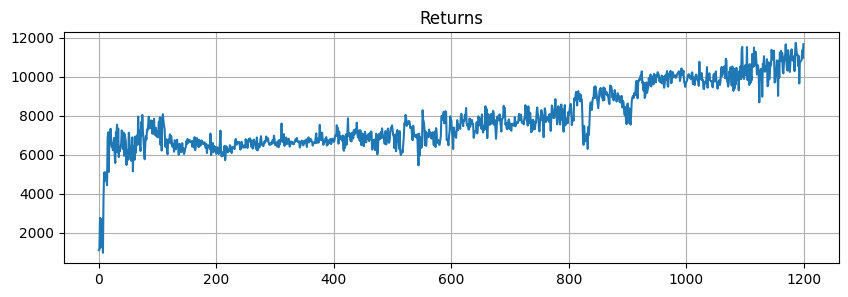

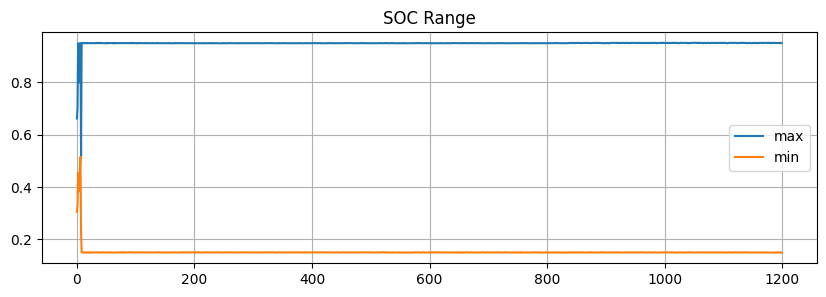

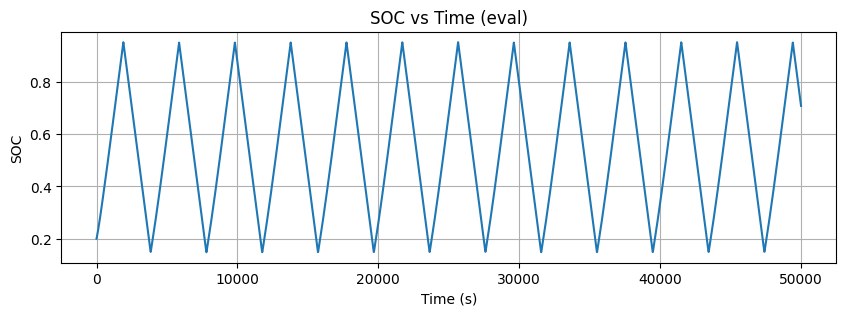

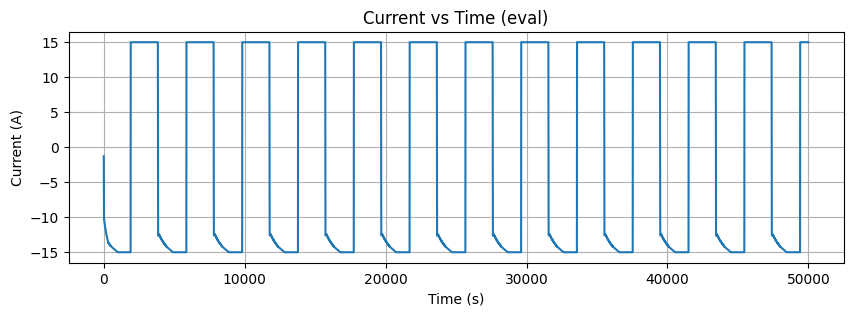

C:\Users\harsh\AppData\Local\Temp\ipykernel_18564\154009130.py:313: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


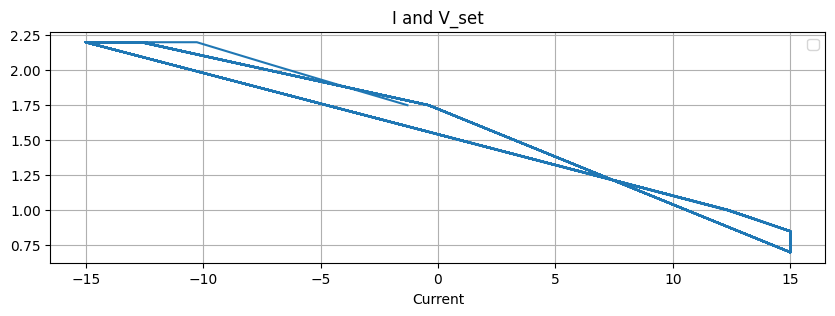

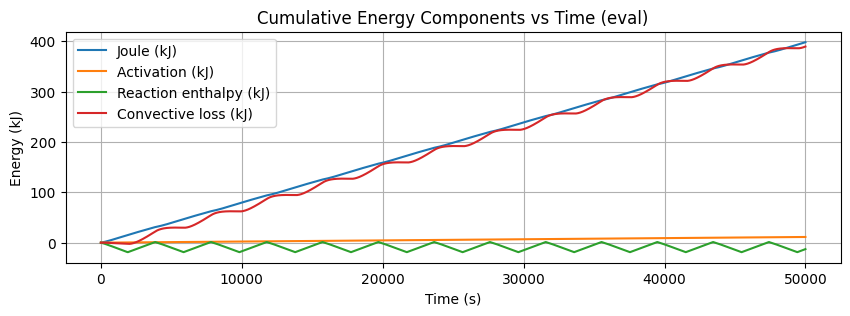

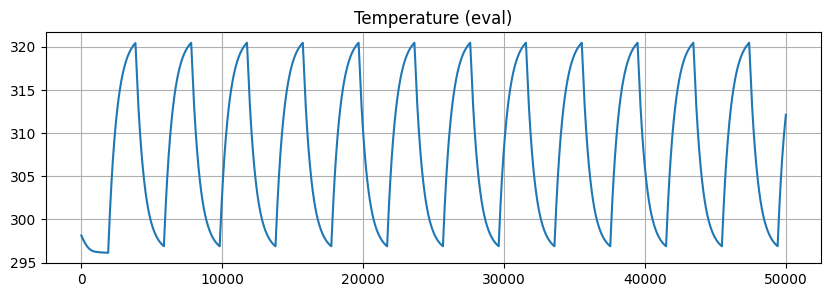

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# ------------------------------------
# CONSTANTS 
# ------------------------------------
F = 96485.33     
R = 8.314        
T0 = 298.15
n = 1            
E0 = 1.26        

C_tot = 1500.0        
V_elec = 0.001
A_elec = 0.5
i0 = 50.0              
alpha = 0.5

dt = 5.0
T_amb = 298.15

nu_H = 2.0
SOC_SCALE = 4.0       

R_ref = 0.05      
Q_ref = 1.67e-5
beta = 0.25

I_max = 15.0
dI_max = 5.0

V_discharge_nom = 0.9
V_charge_nom = 1.8      

k_cross = 2e-6          

deltaH_rxn = -67.4e3

C_th = 500.0
hA = 0.8
T_min = 250
T_max = 400

T_TARGET = 310.15

# Updated reward weights for better thermal control
TEMP_W = 1.5
TEMP_OVER_MARGIN = 5.0
TEMP_OVER_W = 4.0
HOT_LINEAR_W = 0.3        # NEW: linear heat penalty

SOC_W = 800.0
P_EL_W = 0.15
ALIVE_BONUS = 2.0
WRONG_SIGN_W = 40.0
CYCLE_BONUS = 500.0

T_amb_base = T_amb


# ------------------------------------
# ELECTROCHEMISTRY / THERMAL FUNCTIONS
# ------------------------------------
def soc_coulomb(I, soc_prev):
    soc_new = soc_prev - SOC_SCALE * (I*dt)/(n*F*C_tot*V_elec)
    return float(np.clip(soc_new, 1e-6, 1-1e-6))

def eta_act(I, T):
    j = np.abs(I) / A_elec + 1e-12
    arg = np.maximum(1e-12, j/(2*i0))
    eta = (R*T)/(alpha*n*F) * np.arcsinh(arg)
    return np.sign(I)*eta

def E_ocv(soc, T, H):
    s = np.clip(soc, 1e-6, 1-1e-6)
    return E0 + (2*R*T/F)*(np.log((1-s)/s) + np.log(H+1e-12))

def R_ohm(T, Q):
    T = max(250, T)
    Q = max(1e-9, Q)
    return float(R_ref * (298.15/T) * (Q_ref/Q)**beta)

def temperature_next(T_prev,I,Rohm,eta):
    Q_j = I**2 * Rohm
    Q_a = abs(I)*abs(eta)
    Q_rx = - I*(deltaH_rxn)/F
    Q_gen = Q_j + Q_a + Q_rx
    Q_loss = hA*(T_prev-T_amb)
    T_new = T_prev + (Q_gen-Q_loss)/C_th * dt
    return float(np.clip(T_new,T_min,T_max)),Q_j,Q_a,Q_rx,Q_loss

def H_next(H_prev,I):
    delta_H = -(nu_H * I * dt) / (F * V_elec)
    return float(np.clip(H_prev+delta_H,1e-3,5000.0))

def current_from_Vset(V_set,soc,T,H,Q,I_prev=None):
    Rohm = R_ohm(T,Q)
    Eo = E_ocv(soc,T,H)
    I = 0.0 if I_prev is None else I_prev
    for _ in range(60):
        eta = eta_act(I,T)
        V_est = Eo - I*Rohm - eta
        I += 0.5*(V_est-V_set)/(Rohm+1e-6)
        I = np.clip(I,-I_max,I_max)
    return float(I),Rohm,Eo


# ------------------------------------
# ENVIRONMENT
# ------------------------------------
class VRFBEnv_SOCReward:
    def __init__(self):
        self.V_min,self.V_max = 0.7,2.2
        self.Q_min,self.Q_max = 1e-6,5e-5
        self.soc_full = .95
        self.soc_empty = .15
        self.reset()

    def reset(self,soc=0.2,T=None,V_set=None,Q=None,mode=0):
        self.SOC=float(soc)
        self.T=T0 if T is None else float(T)
        self.H=1000.0
        self.mode=int(mode)
        self.V_set=V_charge_nom if V_set is None else V_set
        self.Q=2e-5 if Q is None else Q
        self.I_prev=0.0
        return self._obs()

    def _obs(self):
        return np.array([self.V_set,self.SOC,self.T,self.Q,float(self.mode)],float)

    def _auto_switch(self):
        if self.mode==0 and self.SOC>=self.soc_full: self.mode=1
        if self.mode==1 and self.SOC<=self.soc_empty: self.mode=0

    def step(self,action):
        self._auto_switch()
        dV,dQ = ACTIONS[action]
        self.V_set = np.clip(self.V_set+dV,self.V_min,self.V_max)
        self.Q = np.clip(self.Q+dQ,self.Q_min,self.Q_max)

        if self.mode==0: self.V_set=np.clip(self.V_set,1.75,self.V_max)
        else: self.V_set=np.clip(self.V_set,self.V_min,1.0)

        I,Rohm,Eo = current_from_Vset(self.V_set,self.SOC,self.T,self.H,self.Q)

        if self.mode==0 and I>0: I = -abs(I)*0.7
        if self.mode==1 and I<0: I = abs(I)*0.7

        prev_soc=self.SOC
        self.SOC = soc_coulomb(I,prev_soc)

        eta = eta_act(I,self.T)
        self.T,Qj,Qa,Qrx,Ql = temperature_next(self.T,I,Rohm,eta)

        self.H = H_next(self.H,I)
        self.I_prev=I

        # ---------------- Reward ----------------
        V_t = Eo - I*Rohm - eta
        volt_r = -0.05*abs(V_t-self.V_set)

        temp_dev = abs(self.T-T_TARGET)
        temp_reward = -TEMP_W*(temp_dev/10.0)

        hot_penalty = -HOT_LINEAR_W * max(0,self.T-T_TARGET)

        over = max(0,self.T-(T_TARGET+TEMP_OVER_MARGIN))
        overheat_penalty = -TEMP_OVER_W*(over/5.0)**2

        dSOC = self.SOC-prev_soc
        if self.mode==0:
            soc_r = SOC_W*max(0,dSOC)
            wrong = -WRONG_SIGN_W*max(0,I)
        else:
            soc_r = SOC_W*max(0,-dSOC)
            wrong = -WRONG_SIGN_W*max(0,-I)

        P = abs(I*V_t)*P_EL_W

        bonus=0
        if self.mode==0 and prev_soc<self.soc_full<=self.SOC: bonus+=CYCLE_BONUS
        if self.mode==1 and prev_soc>self.soc_empty>=self.SOC: bonus+=CYCLE_BONUS

        reward = ALIVE_BONUS + volt_r + soc_r + wrong + P + \
                 temp_reward + hot_penalty + overheat_penalty + bonus

        return self._obs(),float(reward),False,{
            "I":I,"V_t":V_t,"Eo":Eo,"Rohm":Rohm,
            "Q_joule":Qj,"Q_activation":Qa,"Q_rxn":Qrx,"Q_loss":Ql
        }


# ------------------------------------
# RL Setup
# ------------------------------------
dV_list=[-0.15,0.0,0.15]
dQ_list=[-0.5e-6,0.0,0.5e-6]
ACTIONS=[(dv,dq) for dv in dV_list for dq in dQ_list]
N_ACTIONS=len(ACTIONS)

def featurize(s):
    V,soc,T,Q,mode=s
    base=np.array([
        1,
        (V-1.45)/0.5,
        (soc-.5)/.5,
        (T-298.15)/50,
        (Q-2e-5)/1e-5,
        mode
    ])
    quad=np.outer(base,base)[np.triu_indices(base.size)]
    return np.concatenate([base,quad])

rng=np.random.RandomState(0)
phi0=featurize(np.array([1.45,.2,298.15,2e-5,0]))
FEATURE_DIM=phi0.size
W=rng.normal(scale=0.01,size=(N_ACTIONS,FEATURE_DIM))

def q_vals(s):
    phi=featurize(s)
    return W.dot(phi),phi

def select_eps_greedy(s,eps):
    if rng.rand()<eps: return rng.randint(N_ACTIONS)
    return np.argmax(q_vals(s)[0])

def q_update(s,a,r,s2,alpha=1e-3,g=0.99):
    q,phi=q_vals(s)
    q2,_=q_vals(s2)
    td=(r+g*np.max(q2)-q[a])
    W[a]+=alpha*td*phi


# ------------------------------------
# TRAIN
# ------------------------------------
env=VRFBEnv_SOCReward()
n_ep=1200; ep_len=2000
eps_start=.1; eps_end=.02

H={"tot":[],"max":[],"min":[]}

for ep in range(n_ep):
    eps=max(eps_end,eps_start*(1-ep/n_ep))
    s=env.reset(soc=0.2+.4*rng.rand(),T=298.15,V_set=1.45,Q=2e-5,mode=0)
    tot=0; socs=[]
    for t in range(ep_len):
        a=select_eps_greedy(s,eps)
        s2,r,_,_=env.step(a)
        q_update(s,a,r,s2)
        s=s2; tot+=r; socs.append(s[1])
    H["tot"].append(tot)
    H["max"].append(max(socs))
    H["min"].append(min(socs))

plt.figure(figsize=(10,3)); plt.plot(H["tot"]); plt.title("Returns"); plt.grid(); plt.show()
plt.figure(figsize=(10,3)); 
plt.plot(H["max"],label="max"); plt.plot(H["min"],label="min");
plt.title("SOC Range"); plt.legend(); plt.grid(); plt.show()


# ------------------------------------
# EVALUATION
# ------------------------------------
def eval_policy(env,steps=10000):
    s=env.reset(soc=0.2,T=298.15,V_set=1.45,Q=2e-5,mode=0)
    T={k:[] for k in ["time","SOC","T","V_set","V_t","Q","I","mode",
                      "E_j","E_a","E_rx","E_l"]}
    Ej=Ea=Erx=El=0

    for t in range(steps):
        a=select_eps_greedy(s,0)
        s,r,_,info=env.step(a)
        I=info["I"]; Vt=info["V_t"]

        Ej+=info["Q_joule"]*dt; Ea+=info["Q_activation"]*dt
        Erx+=info["Q_rxn"]*dt; El+=info["Q_loss"]*dt

        T["time"].append(t*dt)
        T["SOC"].append(s[1]); T["T"].append(s[2])
        T["V_set"].append(s[0]); T["V_t"].append(Vt)
        T["Q"].append(s[3]); T["I"].append(I)
        T["mode"].append(int(s[4]))
        T["E_j"].append(Ej/1000); T["E_a"].append(Ea/1000)
        T["E_rx"].append(Erx/1000); T["E_l"].append(El/1000)
    return T

traj=eval_policy(env,10000)

# Additional Evaluation Plots
plt.figure(figsize=(10,3))
plt.plot(traj["time"], traj["SOC"])
plt.title("SOC vs Time (eval)")
plt.xlabel("Time (s)")
plt.ylabel("SOC")
plt.grid()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(traj["time"], traj["I"])
plt.title("Current vs Time (eval)")
plt.xlabel("Time (s)")
plt.ylabel("Current (A)")
plt.grid()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(traj["I"], traj["V_set"])
plt.title("I and V_set")
plt.xlabel("Current")
plt.legend()
plt.grid()
plt.show()

# Heat & Loss Components
plt.figure(figsize=(10,3))
plt.plot(traj["time"], traj["E_j"], label="Joule (kJ)")
plt.plot(traj["time"], traj["E_a"], label="Activation (kJ)")
plt.plot(traj["time"], traj["E_rx"], label="Reaction enthalpy (kJ)")
plt.plot(traj["time"], traj["E_l"], label="Convective loss (kJ)")
plt.title("Cumulative Energy Components vs Time (eval)")
plt.xlabel("Time (s)")
plt.ylabel("Energy (kJ)")
plt.legend()
plt.grid()
plt.show()




plt.figure(figsize=(10,3)); plt.plot(traj["time"],traj["T"]);
plt.title("Temperature (eval)"); plt.grid(); plt.show()

